In [4]:
import pandas as pd
import pymorphy2
import re
from collections import defaultdict
import numpy as np 
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline

In [5]:
cat = ['политика', 'россия', 'сша', 'европа', 'экономика', 'общество', 'преступность и право', 'происшествия', 'культура', 'интернет']

df = pd.read_pickle('data/dftime_cat.pkl')


#print(df.info()) 
#print(df.shape)
print(df.sample(3))

         id                                              title  cat_id  \
1069   6753                       беспорядки в париже и выборы       5   
2479  15385               беспорядки в манчестере и бирмингеме       3   
5143  27129  8 марта бродячие собаки насмерть загрызли ребё...       7   

                                                  text2  
1069  парижский бунт становится проблемой выборов.бе...  
2479  англияв е в среду было преимущественно спокойн...  
5143   архангельская область, в , в одной из .фото|с...  


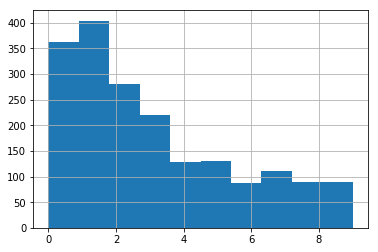

In [6]:
df['cat_id'].hist()

In [10]:
len(df[df['cat_id'].isin([0,1,3,3])])

987

In [12]:
morph = pymorphy2.MorphAnalyzer()

def normal_word(w):
    ''' '''
    w = w.lower()
    info = morph.parse(w)
    if(len(info) > 0):
        return info[0].normal_form
    return w

def word_extraction(sentence):  
    ''' '''
    ignore = {'и','в','а','с','о','к','у','ли', 'можно', 'на', 'снова', 'вот','что','как','без','по','считать','свой',
             'который','два','она','это','она','для','тот','если', 'то', 'такой','от', 'он', 'за', 'из','до','быть',
             'об', 'этом' , 'так', 'его', 'после', 'вновь', 'все', 'а','с', 'ч', 'п', 'в', 'n', 'я', 'a', 'у', 'м', 'й', 
              'т', 'h', 'x', 'е', 'и', 'r', 'н', 'g', 'о', 'm', 'c', 'а', 'к', 't', 'l','стало', 'стал'
             }    
    sentence = re.sub("(не)\s+", "\g<1>", sentence)
    sentence = sentence.replace("ё", "е")    
    sentence = re.sub("[\d\.\-«,%»\"\(\)—]", " ", sentence)
    words = re.sub("[^\w]", " ",  sentence).split() 

    cleaned_text = []
    for w in words:
        w =  normal_word(w)
        if w not in ignore:
            cleaned_text.append(w)        
    return cleaned_text

def text_to_token(texts):
    ''' '''
    text_words = []
    
    frequency = defaultdict(int)
    for text in texts:
        words = word_extraction(text)
        text_words.append(words)
        for token in words:
            frequency[token] += 1

    return [
        [token for token in words if frequency[token] > 1]
            for words in text_words
    ]


def processed_text(df):
    texts = df['text2']
    return text_to_token(texts)


rdf = df[df['cat_id'].isin([0,1,3,3])]

texts = processed_text(rdf)

In [4]:
texts_str = [" ".join(text) for text in texts]
vectorizer = TfidfVectorizer(ngram_range = (1,2), min_df = 3)  
X = vectorizer.fit_transform(texts_str)

In [5]:
def cat_id_vec(id):
    v = np.zeros(10)
    v[id] = 1
    return v
Y = rdf['cat_id'].map(cat_id_vec).values

Y_ = rdf['cat_id'].values
Y_label = rdf['cat_id'].values

In [6]:
from sklearn.decomposition import TruncatedSVD

def encode_svd(x, k=100): 
    svd_model = TruncatedSVD(n_components=k, algorithm='randomized', n_iter=100, random_state=42)
    x1 = svd_model.fit_transform(X) 
    return x1 

In [7]:
%%time
n_svd = 50
X_ = encode_svd(X, n_svd)

CPU times: user 30.8 s, sys: 35 s, total: 1min 5s
Wall time: 18.4 s


In [8]:
np.save('data_x_50.npy', X_)
np.save('data_y.npy', Y_)

In [ ]:
%%time
n_svd = 100
X_ = encode_svd(X, n_svd)

In [ ]:
np.save('data_x_100.npy', X_)